# Applied ML
In this exercise, we will apply propensity score matching and also, learn how to build a classifier of news to directly assign them to categories.

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn import linear_model
import warnings
%matplotlib inline

In [103]:
warnings.filterwarnings("ignore")

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?


#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


We import the *csv* file with *pandas*.

In [104]:
data=pd.read_csv('lalonde.csv')

data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


The table below is a summary of the data's main statistics.

In [105]:
round(data.describe(),2).transpose()

,count,mean,std,min,25%,50%,75%,max
treat,614.0,0.30,0.46,0.0,0.00,0.00,1.00,1.00
age,614.0,27.36,9.88,16.0,20.00,25.00,32.00,55.00
educ,614.0,10.27,2.63,0.0,9.00,11.00,12.00,18.00
black,614.0,0.40,0.49,0.0,0.00,0.00,1.00,1.00
hispan,614.0,0.12,0.32,0.0,0.00,0.00,0.00,1.00
married,614.0,0.42,0.49,0.0,0.00,0.00,1.00,1.00
nodegree,614.0,0.63,0.48,0.0,0.00,1.00,1.00,1.00
re74,614.0,4557.55,6477.96,0.0,0.00,1042.33,7888.50,35040.07
re75,614.0,2184.94,3295.68,0.0,0.00,601.55,3248.99,25142.24
re78,614.0,6792.83,7470.73,0.0,238.28,4759.02,10893.59,60307.93


The variables *black*, *hispan*, *married* and *nodegree* are binary. The mean is thus an indicator of the percentage of these characteristics present in the dataset.

The *age* and *educ* are rather well distributed with mean similar to the median, but are a bit skewed.

At least 25% of the people in the dataset did not have a revenue in 1974 and 1975 (*re74* and *re75*). The difference between the mean and the median for each revenue is non-negligible. The richer part is significantly richer than at least 75% of the population.

In [106]:
treat=data[data['treat']==1]

round(treat.describe(),2).transpose()

,count,mean,std,min,25%,50%,75%,max
treat,185.0,1.00,0.00,1.0,1.00,1.00,1.00,1.00
age,185.0,25.82,7.16,17.0,20.00,25.00,29.00,48.00
educ,185.0,10.35,2.01,4.0,9.00,11.00,12.00,16.00
black,185.0,0.84,0.36,0.0,1.00,1.00,1.00,1.00
hispan,185.0,0.06,0.24,0.0,0.00,0.00,0.00,1.00
married,185.0,0.19,0.39,0.0,0.00,0.00,0.00,1.00
nodegree,185.0,0.71,0.46,0.0,0.00,1.00,1.00,1.00
re74,185.0,2095.57,4886.62,0.0,0.00,0.00,1291.47,35040.07
re75,185.0,1532.06,3219.25,0.0,0.00,0.00,1817.28,25142.24
re78,185.0,6349.14,7867.40,0.0,485.23,4232.31,9643.00,60307.93


The percentage of black people present in the treated group (84%) is a lot higher than in the whole dataset (40%) with *treated* and *control* population.

At least 50% of the people in the treated group did not have a revenue in 1974 and 1975 (25% for the whole dataset). The gap closed in in 1978, after the treatment, where the mean of the treated group is similar to the one of the whole population.

This said, each year the maxima is reached with somebody from the treated group.

In [107]:
control=data[data['treat']==0]

round(control.describe(),2).transpose()

,count,mean,std,min,25%,50%,75%,max
treat,429.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00
age,429.0,28.03,10.79,16.0,19.00,25.00,35.00,55.00
educ,429.0,10.24,2.86,0.0,9.00,11.00,12.00,18.00
black,429.0,0.20,0.40,0.0,0.00,0.00,0.00,1.00
hispan,429.0,0.14,0.35,0.0,0.00,0.00,0.00,1.00
married,429.0,0.51,0.50,0.0,0.00,1.00,1.00,1.00
nodegree,429.0,0.60,0.49,0.0,0.00,1.00,1.00,1.00
re74,429.0,5619.24,6788.75,0.0,0.00,2547.05,9277.13,25862.32
re75,429.0,2466.48,3292.00,0.0,0.00,1086.73,3881.42,18347.23
re78,429.0,6984.17,7294.16,0.0,220.18,4975.50,11688.82,25564.67


As expected, the black community is not well represented in the control group (40%).

Similarly, the mean of the revenues during the first 2 years considered are higher than from the whole population. On the contrary, the mean for the 1978 revenue is a almost equal to the one of the treated group.

In [108]:
print("Dataset {0} 100%\nTreated {1} {2}%\nControl {3} {4}%".format(len(data), 
                                                                    len(treat), 
                                                                    round(len(treat)*100/len(data)),
                                                                    len(control),
                                                                    round(len(control)*100/len(data))))

Dataset 614 100%
Treated 185 30%
Control 429 70%


The treated group represent 30% of the whole dataset.
The following figure presents the distribution of the 1978 revenue for the 2 groups. The treated group (orange) has a smaller median, with a smaller box (quantiles closer to the median). The outliers are more important than in the control group (blue).

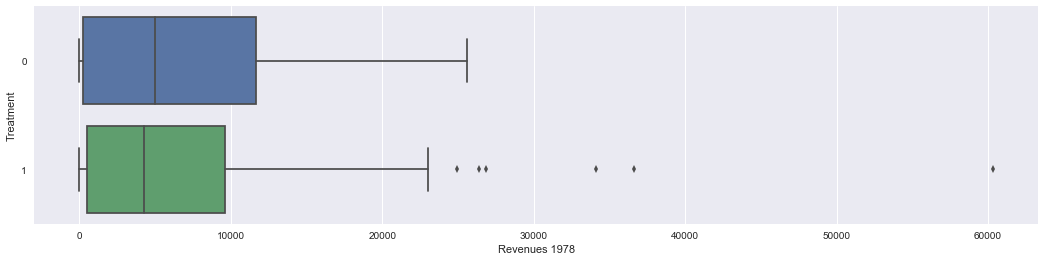

In [109]:
fig, ax = plt.subplots(figsize=(18,4))

sns.boxplot(x="re78",y="treat", data=data, orient="h" )

ax.set_ylabel('Treatment')
ax.set_xlabel('Revenues 1978')

plt.show()

The 3 graphs below present the effect of changing the number of bins on the distribution. Here, we only consider the 1978 revenue but we can see that the overall trend is the similar in each case.

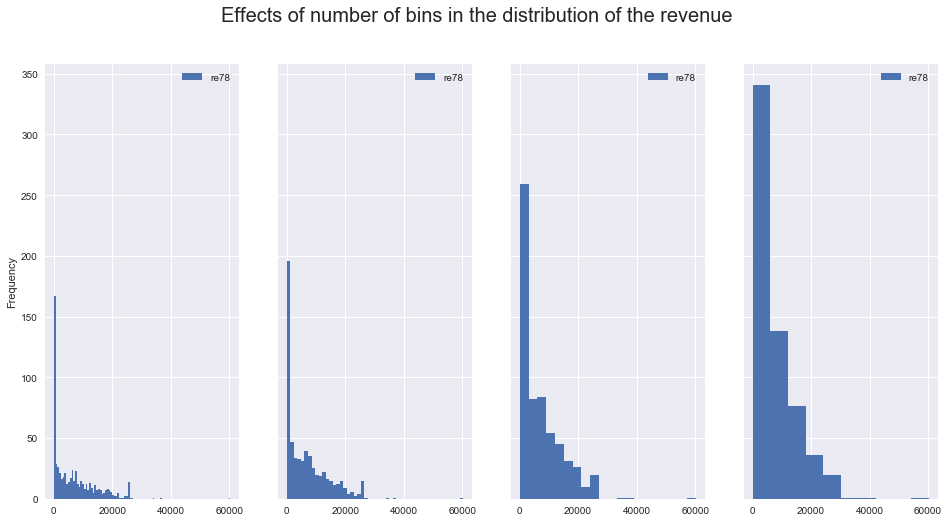

In [110]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(16,8))

plt.suptitle("Effects of number of bins in the distribution of the revenue", fontsize=20)

data.plot(kind='hist', x='treat', y='re78', ax=axs[0], bins=100, grid=True)
data.plot(kind='hist', x='treat', y='re78', ax=axs[1], bins=50, grid=True)
data.plot(kind='hist', x='treat', y='re78', ax=axs[2], bins=20, grid=True)
data.plot(kind='hist', x='treat', y='re78', ax=axs[3], grid=True)

plt.show()

With a high number of bins, as we get closer to 0, the frequency is reduced as it is shared with neighbouring values. This frequency on 0 remains quite important but less than 25% of the overall population (see tables above).

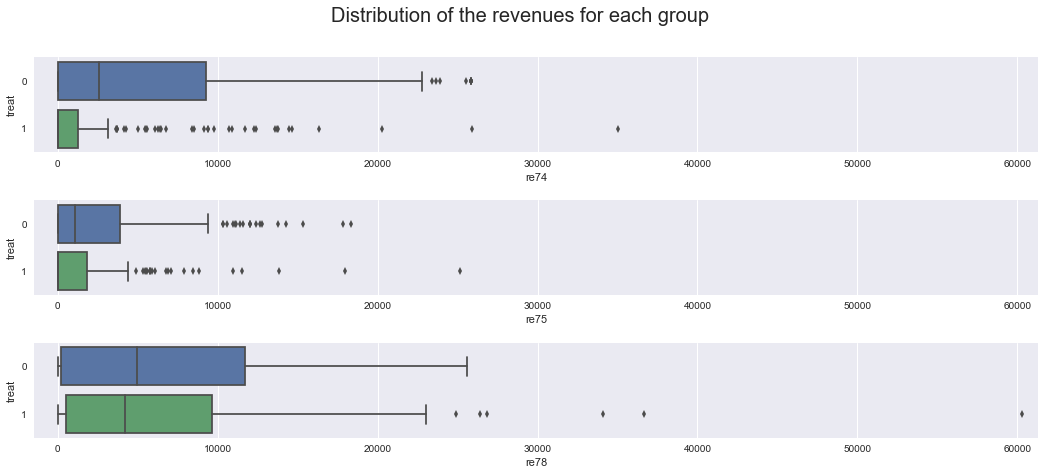

In [111]:
fig, ax = plt.subplots(sharey=True,figsize=(18,7), ncols=1, nrows=3)

plt.suptitle("Distribution of the revenues for each group", fontsize=20)
plt.subplots_adjust( hspace = 0.5)

sns.boxplot(x="re74",y="treat", data=data, ax=ax[0], orient="h")
sns.boxplot(x="re75",y="treat", data=data, ax=ax[1], orient="h")
sns.boxplot(x="re78",y="treat", data=data, ax=ax[2], orient="h")

ax[0].set_xlim([-1500,max(data.re78)+1000])
ax[1].set_xlim([-1500,max(data.re78)+1000])
ax[2].set_xlim([-1500,max(data.re78)+1000])

plt.show()

For the 2 groups, the revenues have increased during these 3 years. The most impressive growth is from the treated group (orange).

The outliers seem more present in the treated group.
We are adding the column for the white race, and divide dataset for treated and untreated people.

In [112]:
# additional dataframe, useful for plots
trained_re78 = data[["treat","re78"]]
# adding the column for the white
data["white"] = np.logical_not((data["black"] | data["hispan"])).astype(int)

Now, we can take a look at some stats for this data

In [113]:
data.ix[:,["black","hispan","white"]].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
black,614.0,0.40,0.49,0.0,0.0,0.0,1.0,1.0
hispan,614.0,0.12,0.32,0.0,0.0,0.0,0.0,1.0
white,614.0,0.49,0.50,0.0,0.0,0.0,1.0,1.0


Since stats does not give us much information about the distribution of the data, now we will plot the distribution of the data by different categories, and we will try to compare are the distribution looks like each other for partic. and not participants

Ploting income in the year 1978 for people that had been participate or had not been participate in training on the same plot and separately

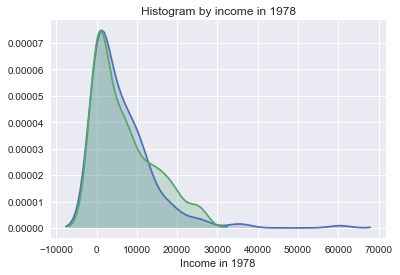

In [114]:
sns.kdeplot(treat["re78"], shade=True)
sns.kdeplot(control["re78"], shade=True)
plt.title("Histogram by income in 1978")
plt.xlabel("Income in 1978")
plt.legend('Treated','Not treated')
plt.show()

Ploting the income in the  two plots, for people that participate and not participate in trainingyear 1978 on.

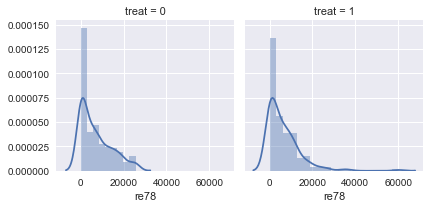

In [115]:
plt.figure()
g = sns.FacetGrid(trained_re78, col="treat") 
g.map(sns.distplot,"re78")
plt.show()

The distribution of income for participants is more tailed distribution: so high values are more likeli in the treated group than at untreated. Also, number of people that has low income is greater in the not-treated group. It seems like that training works, and helps people to have more income, but we will explore more, we do not believe in stats on poor balanced sets
Plotting histogram by age for the different groups.

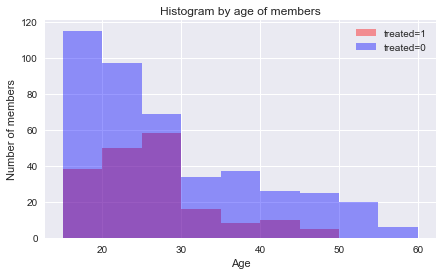

In [116]:
# ploting histogram age, sns
fig, ax = plt.subplots(figsize=(7,4))
#define bins for histogram, according to some age categories
bins_preset = [15,20,25,30,35,40,45,50,55,60]

sns.distplot(treat["age"], bins = bins_preset, kde = False, color = "red", label = "treated=1")
sns.distplot(control["age"], bins = bins_preset, kde = False, color = "blue", label = "treated=0")

ax.set_title('Histogram by age of members')
plt.xlabel('Age')
plt.ylabel('Number of members')
plt.legend()
plt.show()

The trend are relatively similar with important presence of young people (under 30) and less older person (over 30).

In [117]:
pd.DataFrame({"treated age":treat["age"].describe(),
              "control age":control["age"].describe()}).round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
control age,429.0,28.03,10.79,16.0,19.0,25.0,35.0,55.0
treated age,185.0,25.82,7.16,17.0,20.0,25.0,29.0,48.0


The overall distribution of both age group are similar. There is a small variance between mean and median within each groups and between the 2 groups. In the same time, the min and the 25% quantile are similar. The only really change would be the skewed distribution in the control group (*notreated age*).

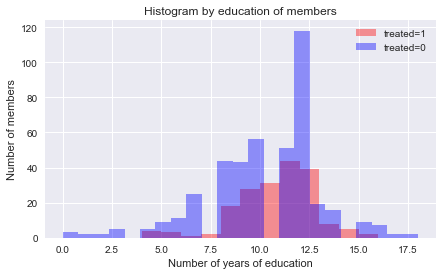

In [118]:
#ploting histogram education, sns
fig, ax = plt.subplots(figsize=(7,4))
sns.distplot(treat["educ"], kde = False, color="red", label = "treated=1")
sns.distplot(control["educ"], kde = False, color="blue", label = "treated=0")
plt.title('Histogram by education of members')
plt.xlabel('Number of years of education')
plt.ylabel('Number of members')
plt.legend()
plt.show()

Even though some gaps appear for the control group (~7.5 years of education), the 2 distribution are slightly different, centered around 10 and 12 respectively. Surpringly, the control group has more inconsistencies with important gaps and outliers even though it has a larger population.

In [119]:
pd.DataFrame({"treated educ":treat["educ"].describe(),
              "control educ":control["educ"].describe()}).round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
control educ,429.0,10.24,2.86,0.0,9.0,11.0,12.0,18.0
treated educ,185.0,10.35,2.01,4.0,9.0,11.0,12.0,16.0


In terms of education, groups look like had the same distribution, they have same mean value, standard deviation, and quantiles have the same values. One can notice that there is no people in the untreated group with less than 4 years education, and that there are some people in treated group.
Plotting histogram by race of participants and people that have not participated.

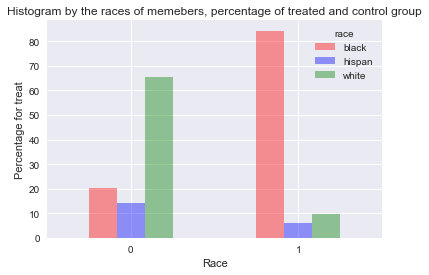

In [120]:
#ploting histogram race, matplot
data["race"] = data[["black","white","hispan"]].idxmax(axis=1)
trained_race = pd.crosstab(data["treat"], data["race"], margins=False, normalize='index')*100

trained_race.plot(kind='bar', stacked=False, color=['red','blue','green'], alpha=0.4, grid=True, rot=0)
plt.title('Histogram by the races of memebers, percentage of treated and control group')
plt.xlabel('Race')
plt.ylabel("Percentage for treat")
plt.show()

These race distribution are not even look like each other. It seems like the minority of untreated people is black people
and the majority of treated ones are black people, opposite for the white. Also, there black people more likely participate in these programs, on the contrary, hispan and white people tend to be non participant more often.
Plotting histogram of married and not one participants and people that have not participated.
The ratio is quite even in the treated group but definitely not in the control group.

In [121]:
pd.DataFrame({"treated married":treat["married"].describe(),
              "control married":control["married"].describe()}).round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
control married,429.0,0.51,0.50,0.0,0.0,1.0,1.0,1.0
treated married,185.0,0.19,0.39,0.0,0.0,0.0,0.0,1.0


In [122]:
pd.DataFrame({"treated nodegree":data["nodegree"].describe(),"notreated nodegree":data["nodegree"].describe()}).round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
notreated nodegree,614.0,0.63,0.48,0.0,0.0,1.0,1.0,1.0
treated nodegree,614.0,0.63,0.48,0.0,0.0,1.0,1.0,1.0


In both group, the *nodegree* characteristic is dominant (at least 50% of each group).

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)


To compute the propensity scores, we must first consider a linear model. For this purpose, we divide the data in two: the explanatory variables (in *X*) and the response variable (*treat* in *y*).

In [123]:
X=data.drop(["treat", "id","white","race"],1)
y=data["treat"]

Fitting the logistic regression on the data created just above. In the end, we only take the scores from the second column [:,1].

In [124]:
logistic = linear_model.LogisticRegression()

logistic.fit(X,y)

prop_score=logistic.predict_proba(X)[:,1]

We then add the newly computed propensity scores to the initial data table which we divide using the *treat* variable.

In [125]:
data["propensity score"]=prop_score

treat=data[data['treat']==1]
control=data[data['treat']==0]

data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,race,propensity score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0,black,0.458074
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0,hispan,0.151980
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0,black,0.750966
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0,black,0.674020
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0,black,0.670590


The following plot represent the distribution of the propensity scores for each of the considered group (*treated* and *untreated*).

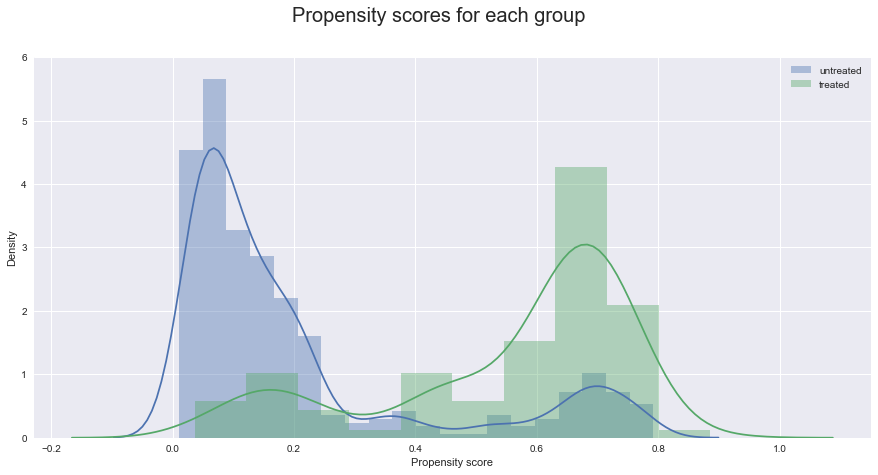

In [126]:
fig, ax = plt.subplots(sharey=True, figsize=(15,7))

plt.suptitle("Propensity scores for each group", fontsize=20)

sns.distplot(control["propensity score"],label="untreated", ax=ax, kde=1)
sns.distplot(treat["propensity score"],label="treated", ax=ax, kde=1)

ax.legend()
ax.set_xlabel('Propensity score')
ax.set_ylabel('Density')
ax.set_ylim(0,6)

plt.show()

We can clearly see the bimodal distributions in both cases, though these two are not balanced.

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [127]:
import networkx as nx
from networkx.algorithms import bipartite

We will be using the *networkx* package to balance the dataset.

First, we create a graph and add nodes to it. Each line of the initial dataset is added to the graph with its propensity score and whether the person was treated or not.

In [128]:
B = nx.Graph()

for i in range(0,len(data)):
    B.add_node(data.iloc[i].id, score=data.iloc[i]["propensity score"], treat=data.iloc[i]["treat"])

We divide the nodes in two categories corresponding to each treatment group.

In [129]:
nodes_c = list(i for i in B if (B.node[i]['treat']==0))
nodes_t = list(i for i in B if (B.node[i]['treat']==1))

For each unique pair composed of the *treat* id and *control* id, we compute a weight based on their similarity. This weight is computed as 1 minus the absolute difference between their propensity scores.

Thus, if a pair of points are similar, their weight will be close to 1.

In [130]:
for t in nodes_t:
    for c in nodes_c:
        w=1-abs(B.node[t]['score']-B.node[c]['score'])
        B.add_edge(t,c,weight=w)

Now, we use the function *max_wieght_matching* to compute the best matching, maximizing their similarities.

Careful, the cell below is very time consuming

In [131]:
matched=nx.max_weight_matching(B, maxcardinality=True)

Now, we transform and clean the resulting matched pairs.

In [132]:
matched=pd.DataFrame.from_dict([matched]).transpose().reset_index()
matched.columns=["treat point", "matched control"]
matched=matched[0:len(treat)]
matched.head()

,treat point,matched control
0,NSW1,PSID238
1,NSW10,PSID394
2,NSW100,PSID188
3,NSW101,PSID385
4,NSW102,PSID131


In the following cell, we create a new control group with only matched point. There is no need to do that with the treatment group as we keep every point from the initial treat table.

In [133]:
matched_control=control[control["id"].isin(matched["matched control"])]
matched_control.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,race,propensity score
189,PSID5,0,25,9,1,0,1,1,14829.6900,13776.53,0.000,0,black,0.374373
190,PSID6,0,37,9,1,0,1,1,13685.4800,12756.05,17833.200,0,black,0.439149
192,PSID8,0,20,12,1,0,0,0,7392.3140,12396.19,17765.230,0,black,0.749558
197,PSID13,0,34,8,0,0,1,1,8038.8720,11404.35,5486.799,1,white,0.085009
199,PSID15,0,22,14,1,0,1,0,748.4399,11105.37,18208.550,0,black,0.631737


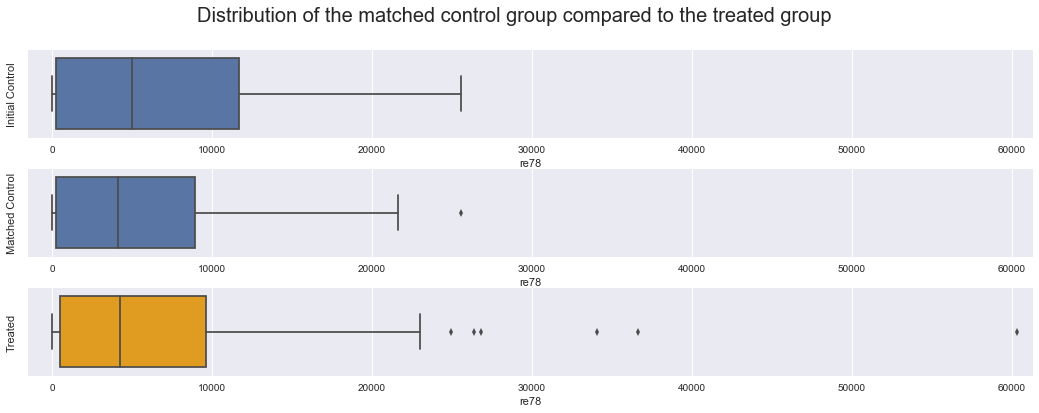

In [134]:
fig, ax = plt.subplots(sharey=True,figsize=(18,6), ncols=1, nrows=3)

plt.suptitle("Distribution of the matched control group compared to the treated group", fontsize=20)
plt.subplots_adjust(hspace=0.35)

sns.boxplot(x="re78", data=control, ax=ax[0])
sns.boxplot(x="re78", data=matched_control, ax=ax[1])
sns.boxplot(x="re78", data=treat, ax=ax[2], color="orange")

ax[0].set_xlim([-1500,max(data.re78)+1000])
ax[1].set_xlim([-1500,max(data.re78)+1000])
ax[2].set_xlim([-1500,max(data.re78)+1000])

ax[0].set_ylabel("Initial Control")
ax[1].set_ylabel("Matched Control")
ax[2].set_ylabel("Treated")

plt.show()

The *matched control* distribution looks more like the treated group than the initial control group.

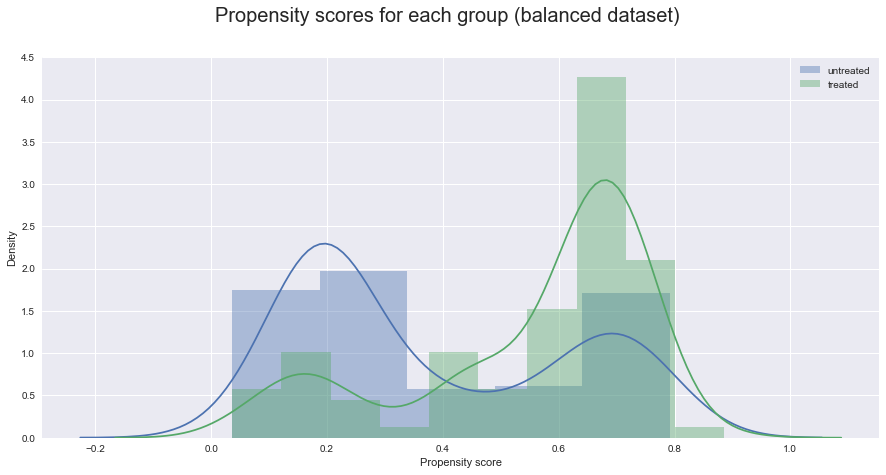

In [135]:
fig, ax = plt.subplots(sharey=True, figsize=(15,7))

plt.suptitle("Propensity scores for each group (balanced dataset)", fontsize=20)

sns.distplot(matched_control["propensity score"],label="untreated", ax=ax, kde=1,  norm_hist=True, hist=True)
sns.distplot(treat["propensity score"],label="treated", ax=ax, kde=1, norm_hist=True, hist=True)

ax.legend()
ax.set_xlabel('Propensity score')
ax.set_ylabel('Density')
ax.set_ylim(0,4.5)

plt.show()

The bimodal distributions are better related than in the initial dataset.

In [136]:
pd.DataFrame({" treated black":treat["black"].describe(),
              " matched control black":matched_control["black"].describe(),
              "treated hispanic":treat["hispan"].describe(),
              "matched control hispanic":matched_control["hispan"].describe()
              }).round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
matched control black,185.0,0.47,0.50,0.0,0.0,0.0,1.0,1.0
treated black,185.0,0.84,0.36,0.0,1.0,1.0,1.0,1.0
matched control hispanic,185.0,0.10,0.30,0.0,0.0,0.0,0.0,1.0
treated hispanic,185.0,0.06,0.24,0.0,0.0,0.0,0.0,1.0


There is still a quite important difference in the origins from the treated group and the control group with respectively 47% and 84% of black people.

In [137]:
pd.DataFrame({"treated married":treat["married"].describe(),
              "matched control married":matched_control["married"].describe()
             }).round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
matched control married,185.0,0.18,0.39,0.0,0.0,0.0,0.0,1.0
treated married,185.0,0.19,0.39,0.0,0.0,0.0,0.0,1.0


Considering the *married* characteristic, it seems evenly distributed in the 2 groups.

In [138]:
pd.DataFrame({"treated nodegree":treat["nodegree"].describe(),
              "matched control nodegree":matched_control["nodegree"].describe()
              }).round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
matched control nodegree,185.0,0.68,0.47,0.0,0.0,1.0,1.0,1.0
treated nodegree,185.0,0.71,0.46,0.0,0.0,1.0,1.0,1.0


The distribution of the *nodegree* variable in both groups are look alike (similar mean, same median and 75% quantile, etc.).

In [139]:
pd.DataFrame({"treated age":treat["age"].describe(),
              "matched control age":matched_control["age"].describe()
             }).round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
matched control age,185.0,23.17,9.34,16.0,17.0,19.0,24.0,55.0
treated age,185.0,25.82,7.16,17.0,20.0,25.0,29.0,48.0


The age distribution are less alike than before. The mean are similar but the difference between the 2 medians and the different quantiles increased.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

We will repeat the process done above but this time we want the matching pairs to have the same value for the *black* variable. The 2 persons in each pair will then be both black or both not black (hispanic or white).

Indeed, we saw in the first tables that the *black* variable is the only to change much whether we were in the treat group (85% of black people) or the control group (40%).

We create a new graph with the same nodes (one for each person in the initial dataset, plus the values of the propensity score, whether they are black or not and if the treatment occurred).

In [140]:
B.clear()
B = nx.Graph()

for i in range(0, len(data)):
    B.add_node(data.iloc[i].id, score=data.iloc[i]["propensity score"], 
               black=data.iloc[i]["black"], treat=data.iloc[i]["treat"])

We thus divide the node in 4 subsets: 
                  - control &  black
                  - control &  not black
                  - treat   &  black
                  - treat   &  not black

In [141]:
nodes_cb  = list(i for i in B if ((B.node[i]['treat']==0) & (B.node[i]['black']==1)))
nodes_cnb = list(i for i in B if ((B.node[i]['treat']==0) & (B.node[i]['black']==0)))

nodes_tb  = list(i for i in B if ((B.node[i]['treat']==1) & (B.node[i]['black']==1)))
nodes_tnb = list(i for i in B if ((B.node[i]['treat']==1) & (B.node[i]['black']==0)))

Once again, we repeat the process of attributing weight for each created pairs, but here we do it for the 2 categories (*black* and *not black*). Thus, we have computed weights only within these categories.

In [142]:
for t in nodes_tb:
    for c in nodes_cb:
        w = 1 - abs(B.node[t]['score'] - B.node[c]['score'])
        B.add_edge(t,c, weight = w)
               
for t in nodes_tnb:
    for c in nodes_cnb:
        w = 1 - abs(B.node[t]['score'] - B.node[c]['score'])
        B.add_edge(t,c, weight = w)

We use the *max_weight_matching* function to maximize the similarities between the 2 matched points.

In [143]:
matched=nx.max_weight_matching(B, maxcardinality=True)

We clean again the resulting matching points.

In [144]:
matched=pd.DataFrame.from_dict([matched]).transpose().reset_index()
matched.columns=["treat point", "matched control"]
matched=matched[0:len(treat)]
matched.head()

,treat point,matched control
0,NSW1,PSID238
1,NSW10,PSID394
2,NSW100,PSID208
3,NSW102,PSID389
4,NSW104,PSID423


We create a new control subset by getting the id of the matched control point and adding the different values for each variable to it.

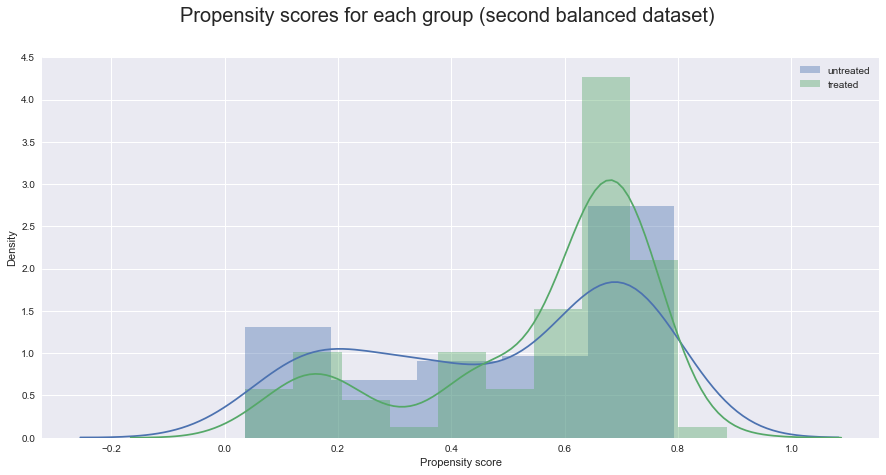

In [145]:
matched_control=control[control["id"].isin(matched["matched control"])]

fig, ax = plt.subplots(sharey=True, figsize=(15,7))

plt.suptitle("Propensity scores for each group (second balanced dataset)", fontsize=20)

sns.distplot(matched_control["propensity score"],label="untreated", ax=ax, kde=1)
sns.distplot(treat["propensity score"],label="treated", ax=ax, kde=1)

ax.legend()
ax.set_xlabel('Propensity score')
ax.set_ylabel('Density')
ax.set_ylim(0,4.5)
plt.show()

We can clearly see that the 2 curves are closer together than in the previous *propensity score distribution* graph. Now, the treat and the matched control groups are alike.

In [146]:
matched_control.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,race,propensity score
189,PSID5,0,25,9,1,0,1,1,14829.6900,13776.53,0.000,0,black,0.374373
190,PSID6,0,37,9,1,0,1,1,13685.4800,12756.05,17833.200,0,black,0.439149
192,PSID8,0,20,12,1,0,0,0,7392.3140,12396.19,17765.230,0,black,0.749558
197,PSID13,0,34,8,0,0,1,1,8038.8720,11404.35,5486.799,1,white,0.085009
199,PSID15,0,22,14,1,0,1,0,748.4399,11105.37,18208.550,0,black,0.631737


Now, we will out matched_control and treat in one data frame

In [147]:
match_data.head()

NameError: name 'match_data' is not defined

We are adding the column for the white race

In [ ]:
# additional dataframe, useful for plots
match_data_re78 = match_data[["treat","re78"]]
# adding the column for the white
match_data["white"] = np.logical_not((match_data["black"] | match_data["hispan"])).astype(int)
match_data.head()

Now, we can take a look at some stats for this data

In [ ]:
match_data.describe().round(2).transpose()

Since stats does not give us much information about the distribution of the data, now we will plot the distribution of the data by different categories, and we will try to compare are the distribution looks like each other for partic. and not participants
Plotting histogram by age for the different groups
Ploting histogram of age for participants, easier to compare

In [ ]:
#ploting histogram age, matplot
fig, ax = plt.subplots(figsize=(7,4))
plt.hist([treat["age"], matched_control["age"]],bins = bins_preset, color=['r','b'], alpha=0.4)
plt.title('Histogram by age of members')
plt.xlabel('Age')
plt.ylabel('Number of members')
labels = ["treated=1","treated=0"]
ax.legend(labels)
plt.show()

In [ ]:
pd.DataFrame({"treated age":treat["age"].describe(),
              "control age":matched_control["age"].describe()
             }).round(2).transpose()

These distribution are not very similiar. We can notice that we have no many people that are participants and older than 50, and there is for people under 30, largely different trend, the number of treated from 16 to 30 age increase while number of matched_control from 16 to 30 age decrese. These sets are not good match speaking from age perspective.

The age distributions are looking more and more different.

In [ ]:
#ploting histogram education, sns
fig, ax = plt.subplots(figsize=(7,4))
sns.distplot(treat["educ"], kde = False, color="red", label = "treated=1")
sns.distplot(matched_control["educ"], kde = False, color="blue", label = "treated=0")
plt.title('Histogram by education of members')
plt.xlabel('Number of years of education')
plt.ylabel('Number of members')
plt.legend()
plt.show()

Ploting histogram of education for participants, easier to compare

In [ ]:
pd.DataFrame({"treated educ":treat["educ"].describe(),
              "control educ":matched_control["educ"].describe()
             }).round(2).transpose()

In terms of education, groups look like had the same distribution, they have same mean value, standard deviation, and quantiles have the same values. One can notice that there is no people in the untreated group with less than 4 years education, and that there are some people in treated group. Compared to previous group, there is a better matching of people that has little years spend in eductation. In terms of education we had good matching

Plotting histogram by race of participants and people that have not participated

In [ ]:
#ploting histogram race, matplot
match_data["race"] = match_data[["black","white","hispan"]].idxmax(axis=1)
trained_race = pd.crosstab(match_data["treat"], match_data["race"], margins=False, normalize='index')*100

trained_race.plot(kind='bar', stacked=False, color=['red','blue','green'], alpha=0.4, grid=True, rot=0)
plt.title('Histogram by the races of memebers, percentage of treated and control group')
plt.xlabel('Race')
plt.ylabel("Percentage for treat")
plt.show()

These race distribution are now a lot better compared to the previous repartition.
Plotting histogram of married and not one participants and people that have not participated

In [ ]:
# plotting histogram married, matplot
# categories = {0: 'Not Married', 1: 'Married'}
trained_married = pd.crosstab(match_data["treat"], match_data["married"], margins=False, normalize='index')*100
trained_married.index= ["Treated","Not treated"]

trained_married.plot(kind='bar', stacked=False, color=['red','blue'], alpha=0.4, grid=True, rot=0)
plt.title('Histogram of married memebers, how much married in treated or notreated group')
plt.xlabel('Treated')
plt.ylabel("Percentage for treat")
plt.show()

In [ ]:
pd.DataFrame({"treated married":treat["married"].describe(),
              "control married":matched_control["married"].describe()
             }).round(2).transpose()

There is also good matching between the number of married people between both group, they are good matched
Plotting hstogram by degree of participants and non-participants

In [ ]:
trained_degree = pd.crosstab(match_data["treat"], match_data["nodegree"], margins=False, normalize='index')*100
trained_degree.index= ["Treated","No Treated"]

trained_degree.plot(kind='bar', stacked=False, color=['red','blue'], alpha=0.4, grid=True, rot=0)
plt.title('Histogram of degree, how much with degree in treated or notreated group')
plt.xlabel('Degree')
plt.ylabel("Percentage for treat")
plt.show()

In [ ]:
pd.DataFrame({"treated nodegree":treat["nodegree"].describe(),
              "control nodegree":matched_control["nodegree"].describe()
             }).round(2).transpose()

There is very good matching in terms of nodegree atribute between these groups
Since we have manage very good matching in terms of race, married, degree, education and a let s say years, now it we will take a look if the income after the training - in terms of attribute re78 of treat indeed increase more than in control group
Ploting income in the year 1978 for people from matched control and treat group.

In [ ]:
sns.kdeplot(treat["re78"], shade=True)
sns.kdeplot(matched_control["re78"], shade=True)
plt.title("Histogram by income in 1978")
plt.xlabel("Income in 1978")
plt.legend('Treated','Not treated')
plt.show()

In [ ]:
plt.figure()
g = sns.FacetGrid(match_data_re78, col="treat") 
g.map(sns.distplot,"re78")
plt.show()

In [ ]:
fig, ax = plt.subplots(sharey=True,figsize=(18,6), ncols=1, nrows=3)

plt.suptitle("Distribution of the matched control group compared to the treated group", fontsize=20)
plt.subplots_adjust(hspace=0.35)

sns.boxplot(x="re78", data=control, ax=ax[0])
sns.boxplot(x="re78", data=matched_control, ax=ax[1])
sns.boxplot(x="re78", data=treat, ax=ax[2], color="orange")

ax[0].set_xlim([-1500,max(data.re78)+1000])
ax[1].set_xlim([-1500,max(data.re78)+1000])
ax[2].set_xlim([-1500,max(data.re78)+1000])

ax[0].set_ylabel("Initial Control")
ax[1].set_ylabel("Matched Control")
ax[2].set_ylabel("Treated")

plt.show()

The distribution of income for participants is more tailed distribution: so high values are more likeli in the treated group than at untreated. There is a little bit larger number of people with low income in control group than in treated group. Also, number of people that has low income is greater in the not-treated group. Lastly, it seems like that training helps people to have larger income

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories.

# 2.1
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)). 

In [73]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

Loading data for the second part.

In [38]:
#Load 20newsgroup dataset
newsgroups = fetch_20newsgroups()

Once we have the new dataset for this question we are going to create the TF-IDF vector.

In [54]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups.data)
vectors.shape #Just to have an idea of the vector properties

(11314, 130107)

Now that we have the TF-IDF vector computed for everty article we are going to split the dataset into a training, a testing and a validation set. (10% validation and 10% testing).

In [65]:
#list(newsgroups_test.target_names) #Testing targetNames
x_train, x_, y_train, y_ = train_test_split(vectors, newsgroups['target'], test_size=0.2)

#Spliting for validation from the rest of the data (x_, y_). It's a 20% divided into two -> 10% each
x_test, x_validation, y_test, y_validation = train_test_split(x_, y_, test_size=0.5)

# 2.2
Now it's time to create a random forest for the training set.

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

Training a random forest.

In [71]:
randomForest = RandomForestClassifier()
randomForest.fit(x_train, y_train) #Build a forest of trees for this training set

randomForest.score(x_test, y_test) #How good is the model with default parameters

0.65870910698496909

As we can see from the previous result, it is far from 1, so we are going to try to find the good parameters for the validation set by the *number of estimator* and the *max depth of the tree* using a grid search.

In [95]:
n_estimators_vector = [300, 800, 1100]
max_depth_vector = [50, 80]

#Initializing best values
score = 0
n_estimators = 0
max_depth = 0

#GridSearch function
for n_estimators_i in n_estimators_vector:
    for max_depth_i in max_depth_vector:
        forest = RandomForestClassifier(n_estimators = n_estimators_i, max_depth = max_depth_i)
        forest.fit(x_train, y_train)
        currentScore = forest.score(x_validation, y_validation)
        if (currentScore > score): #updating best
            score = currentScore
            n_estimators = n_estimators_i
            max_depth = max_depth_i
            classification = forest
            
print("Best score: ", score)
print("Best n_estimators: ", n_estimators)
print("Best max_depth: ", max_depth)


Best score:  0.860424028269
Best n_estimators:  1100
Best max_depth:  80


In [88]:
forest.score(x_test, y_test)

0.72413793103448276

In [89]:
forest.best_params_



{'max_depth': 30, 'n_estimators': 4000}

Best score  1
